In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Step 3 outputs
sessions = pd.read_csv("Files\\Code Generated CSV\\sessions_master.csv")
stations = pd.read_csv("Files\\Code Generated CSV\\station_aggregates.csv")

print("Sessions shape:", sessions.shape)
print("Stations shape:", stations.shape)


Sessions shape: (262, 28)
Stations shape: (154, 19)


In [5]:
# Compute demand features at station level
demand_features = sessions.groupby('station_key').agg({
    'energy_consumed_kwh': 'mean',
    'charging_duration_hours': 'mean',
    'state_of_charge_start_': 'mean',
    'state_of_charge_end_': 'mean'
}).reset_index()

# Calculate SOC delta (avg)
demand_features['avg_soc_delta'] = demand_features['state_of_charge_end_'] - demand_features['state_of_charge_start_']

# Weekend share
sessions['is_weekend'] = sessions['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_share = sessions.groupby('station_key')['is_weekend'].mean().reset_index().rename(columns={'is_weekend': 'weekend_share'})

# Merge weekend share
demand_features = demand_features.merge(weekend_share, on='station_key', how='left')

demand_features.head()


,station_key,energy_consumed_kwh,charging_duration_hours,state_of_charge_start_,state_of_charge_end_,avg_soc_delta,weekend_share
0,ather grid bandra west,41.157014,0.890000,31.467845,77.452109,45.984264,0.000000
1,ather grid hiranandani,71.040198,4.036667,44.698859,79.013108,34.314248,0.333333
2,ather grid sewri,21.134045,0.650000,44.714215,79.201179,34.486964,1.000000
3,atum charge borivali,55.185766,2.510000,63.033723,62.582634,-0.451089,0.000000
4,atum charge ghatkopar,48.502887,1.110000,28.208935,64.312220,36.103285,0.000000


In [6]:
# Merge demand features with supply (station aggregates)
feature_df = stations.merge(demand_features, on='station_key', how='left')

# Handle NaNs (if any)
feature_df.fillna(0, inplace=True)

feature_df.head()


,station_key,station_name,operator,energy_consumed_kwh_sum,energy_consumed_kwh_mean,charging_duration_hours_mean,charging_rate_kw_mean,sessions_count,popular_vehicle_model,peak_time_of_day,...,address,charging_types,amenities,stations_within_2km,energy_consumed_kwh,charging_duration_hours,state_of_charge_start_,state_of_charge_end_,avg_soc_delta,weekend_share
0,ather grid bandra west,Ather Grid - Bandra West,Ather,41.157014,41.157014,0.890000,46.129689,1,TATA Tiago,Morning,...,"Linking Road, Opp National College, Bandra Wes...",DC 25kW,Street Parking,2,41.157014,0.890000,31.467845,77.452109,45.984264,0.000000
1,ather grid hiranandani,Ather Grid - Hiranandani,Ather,213.120594,71.040198,4.036667,18.247259,3,TATA Tiago,Evening,...,"Hiranandani Gardens, Powai, Mumbai",DC Fast 25kW,Parking,5,71.040198,4.036667,44.698859,79.013108,34.314248,0.333333
2,ather grid sewri,Ather Grid - Sewri,Ather,21.134045,21.134045,0.650000,32.292046,1,Hyundai Kona,Night,...,"Next to VRL Logistics, Ashok Gardens, PD’Mello...",DC Fast 25kW,"Parking, App Connect",3,21.134045,0.650000,44.714215,79.201179,34.486964,1.000000
3,atum charge borivali,ATUM Charge - Borivali,ATUM,110.371533,55.185766,2.510000,30.206715,2,TATA Curvv,Afternoon,...,"Borivali West, Mumbai","AC 7.4kW, DC 25kW",Parking,3,55.185766,2.510000,63.033723,62.582634,-0.451089,0.000000
4,atum charge ghatkopar,ATUM Charge - Ghatkopar,ATUM,48.502887,48.502887,1.110000,43.609707,1,Hyundai Kona,Night,...,"Ghatkopar East, Mumbai","AC 7.4kW, DC 25kW",Parking,3,48.502887,1.110000,28.208935,64.312220,36.103285,0.000000


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Select features for scoring
score_cols = ['sessions_count', 'energy_consumed_kwh_mean', 'charging_duration_hours_mean', 'avg_soc_delta', 'weekend_share', 'stations_within_2km']
scaler = MinMaxScaler()
feature_df[[col + '_norm' for col in score_cols]] = scaler.fit_transform(feature_df[score_cols])

# Compute weighted score
feature_df['suitability_score'] = (
    0.35 * feature_df['sessions_count_norm'] +
    0.25 * feature_df['energy_consumed_kwh_mean_norm'] +
    0.15 * feature_df['avg_soc_delta_norm'] +
    0.10 * feature_df['charging_duration_hours_mean_norm'] +
    0.15 * (1 - feature_df['stations_within_2km_norm'])  # fewer nearby stations = better
)

feature_df[['station_key', 'station_name', 'suitability_score']].sort_values(by='suitability_score', ascending=False).head(10)


,station_key,station_name,suitability_score
107,tata power,Tata Power Charging Station,0.744514
106,tata power,Tata Power,0.679493
96,statiq kanjurmarg,Statiq - Kanjurmarg,0.574722
97,statiq kharghar central park,Statiq - Kharghar Central Park,0.472370
108,tata power airoli,Tata Power - Airoli,0.453566
13,charge zone,Charge Zone,0.438631
26,evteq malad,EVteQ - Malad,0.438008
89,oberoi mall goregaon,"Oberoi Mall, Goregaon",0.432961
1,ather grid hiranandani,Ather Grid - Hiranandani,0.428933
49,kazam kurla,Kazam - Kurla,0.427592


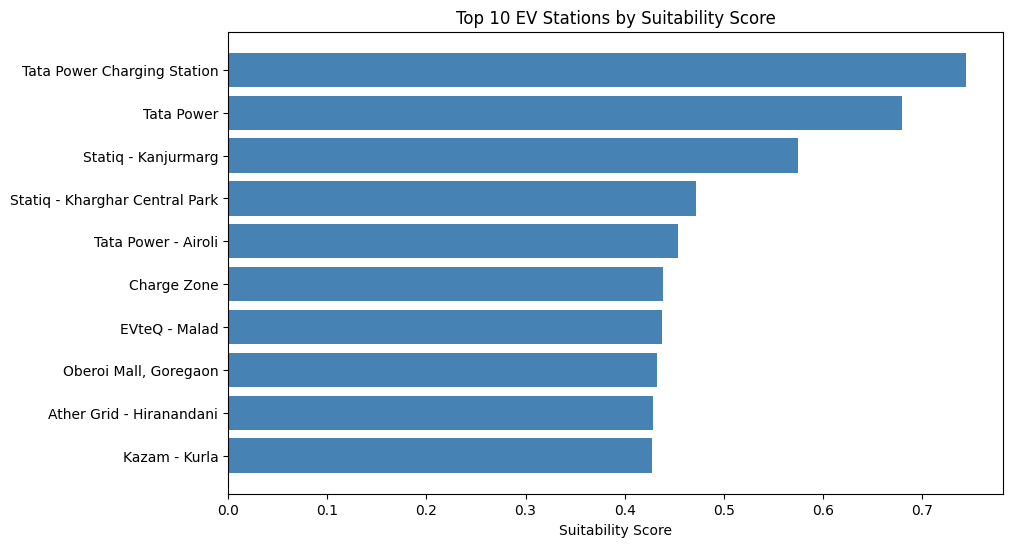

In [8]:
# Export final dataset
feature_df.to_csv("station_suitability_scores.csv", index=False)

# Bar plot for Top 10 stations
top10 = feature_df.sort_values(by='suitability_score', ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(top10['station_name'], top10['suitability_score'], color='steelblue')
plt.xlabel("Suitability Score")
plt.title("Top 10 EV Stations by Suitability Score")
plt.gca().invert_yaxis()
plt.show()


Note: you may need to restart the kernel to use updated packages.


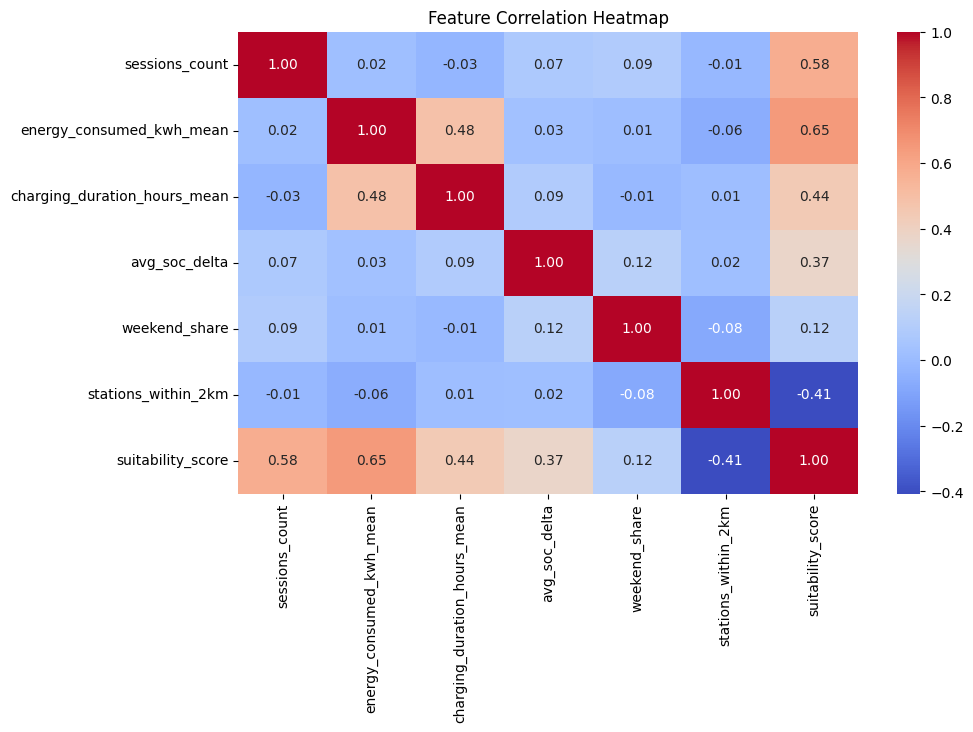


Correlation with Suitability Score:
suitability_score               1.000000
energy_consumed_kwh_mean        0.646163
sessions_count                  0.576721
charging_duration_hours_mean    0.444376
avg_soc_delta                   0.372083
weekend_share                   0.122551
stations_within_2km            -0.407072
Name: suitability_score, dtype: float64


In [9]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation
corr_features = ['sessions_count', 'energy_consumed_kwh_mean', 'charging_duration_hours_mean',
                 'avg_soc_delta', 'weekend_share', 'stations_within_2km', 'suitability_score']

# Compute correlation matrix
corr_matrix = feature_df[corr_features].corr()

# Display correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Print sorted correlation with suitability_score
print("\nCorrelation with Suitability Score:")
print(corr_matrix['suitability_score'].sort_values(ascending=False))
